## Task 11

Checking relationship between variance and mse under \alpha = 0.3, \beta = 0.3 case

In [24]:
import argparse
import yaml
import numpy as np
import pickle as pkl
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from itertools import product
from datetime import datetime
import json
import hashlib
import os
import matplotlib.pyplot as plt

from algorithms import BMP
from data_generation import GaussianDataGenerator

In [25]:
p = 300
n = 600
m = 20
noise_level = 0.2

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, random_seed=1)
_ = Data_Geneartor.shuffle()

In [26]:
(
    test_true_signal,
    test_dictionary,
    true_indices,
    true_coefficients,
    test_perturbed_signal,
) = Data_Geneartor.get_current_shuffle()
print(test_perturbed_signal[:5])
print(true_coefficients[:5])

[[ 0.05826719]
 [-0.329659  ]
 [-0.62405756]
 [ 0.19549826]
 [ 0.29230804]]
[[ 0.64427199]
 [-0.96876819]
 [ 0.21446787]
 [ 0.18492569]
 [ 1.33144795]]


In [27]:
train_seed = 33
(
    train_true_signal,
    train_dictionary,
    true_indices,
    true_coefficients,
    train_perturbed_signal,
) = Data_Geneartor.keep_coef_reshuffle(seed = train_seed)

In [31]:
model_params = {
    'N_bag': 59,
    'K': 1,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

bmp_model = BMP(**model_params)

In [32]:
bmp_model.fit(train_dictionary, train_perturbed_signal)
y_pred = bmp_model.predict(test_dictionary)
bmp_model.score(test_dictionary, test_perturbed_signal)

0.05449637530389502

In [33]:
bmp_model.pred_corr(test_dictionary).shape

(1711,)

In [144]:
test_num = 50

# variance because of bagging

def cal_bagging_variance(n, p, m, data_seed, noise_level, model_params, test_num):
    Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
    test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()
    coef = np.zeros((test_dictionary.shape[1], 1))
    coef[true_indices] = true_coefficients
    coef = coef.ravel()
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + 100)
    y_pred_lst = []
    y_pred_re_lst = []
    coef_lst = []
    coef_re_lst = []
    for test_i in range(test_num):
        _, train_dictionary_resample, _, _, train_perturbed_signal_resample = Data_Geneartor.keep_coef_reshuffle(seed = data_seed + test_i)
        model_params['random_seed'] = data_seed + test_i
        bmp_model_single = BMP(**model_params)
        bmp_model_single.fit(train_dictionary, train_perturbed_signal)
        coef_lst.append(bmp_model_single.coefficients.reshape(-1, 1))
        bmp_model2 = BMP(**model_params)
        bmp_model2.fit(train_dictionary_resample, train_perturbed_signal_resample)
        coef_re_lst.append(bmp_model2.coefficients.reshape(-1, 1))
        y_pred_re = bmp_model2.predict(test_dictionary)
        y_pred_re_lst.append(y_pred_re)
        y_pred = bmp_model_single.predict(test_dictionary)
        y_pred_lst.append(y_pred)
    y_pred_mat = np.concatenate(y_pred_lst, axis = 1)
    y_pred_re_mat = np.concatenate(y_pred_re_lst, axis = 1)
    coef_mat = np.concatenate(coef_lst, axis = 1)
    coef_re_mat = np.concatenate(coef_re_lst, axis = 1)
    
    return y_pred_mat, y_pred_re_mat, test_true_signal, test_perturbed_signal, coef_mat, coef_re_mat, coef, true_indices

In [166]:
model_params = {
    'N_bag': 1,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 300
n = 600
m = 20
noise_level = 0.2
data_seed = 2

y_pred_mat, y_pred_re_mat, test_true_signal, test_perturbed_signal, coef_mat, coef_re_mat, coef, true_indices = cal_bagging_variance(n, p, m, data_seed, noise_level, model_params, 1000)

In [167]:
y_pred_mat.shape

(600, 1000)

In [168]:
en_pred = np.mean(y_pred_mat, axis=1).reshape(-1, 1)

In [169]:
test_true_signal.shape

(600, 1)

In [170]:
mse = np.mean((test_true_signal - en_pred)**2)
mse

0.004568843089159411

In [171]:
test_err = np.mean((test_perturbed_signal - en_pred)**2)
test_err

0.044543106404829225

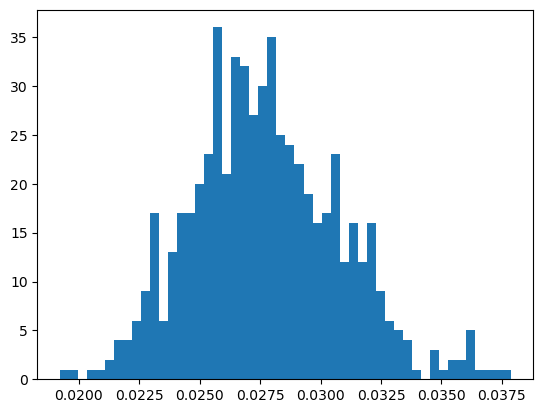

In [172]:
pred_var = np.var(y_pred_mat, axis=1)
plt.hist(pred_var, bins=50)
plt.show()

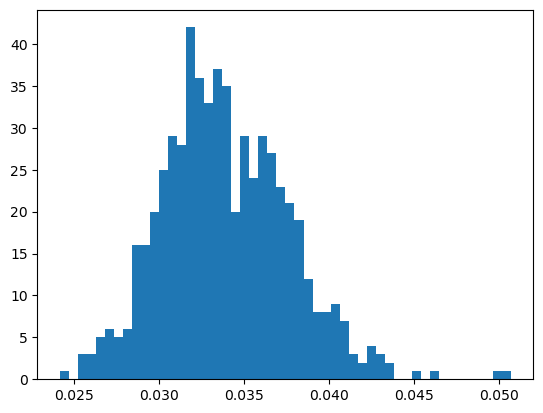

In [174]:
pred_re_var = np.var(y_pred_re_mat, axis=1)
plt.hist(pred_re_var, bins=50)
plt.show()

In [175]:
np.mean(pred_var)

0.02774428124886441

In [176]:
pred_corr = np.corrcoef(y_pred_mat, rowvar=False)
pred_corr_utri = pred_corr[np.triu_indices(pred_corr.shape[0], k=1)]
np.mean(pred_corr_utri)

0.37417507897739277

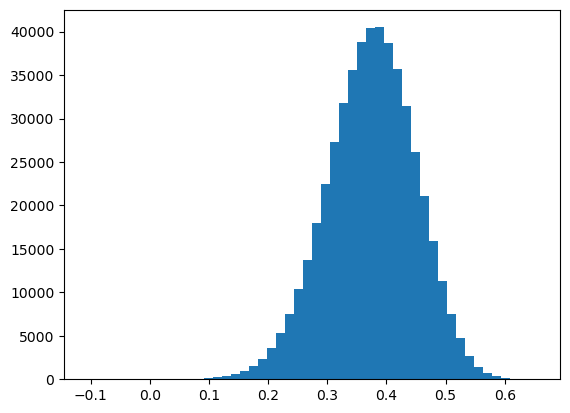

In [177]:
plt.hist(pred_corr_utri, bins = 50)
plt.show()

In [178]:
np.mean(pred_re_var)

0.03393223925904527

In [179]:
pred_corr = np.corrcoef(y_pred_re_mat, rowvar=False)
pred_corr_utri = pred_corr[np.triu_indices(pred_corr.shape[0], k=1)]
np.mean(pred_corr_utri)

0.2573670606428

In [180]:
mse / np.mean(pred_var)

0.16467693101065348

coef

In [181]:
coef_mat.shape

(300, 1000)

In [182]:
true_indice_coef = coef_mat[true_indices, :]

In [183]:
coef_avg = np.mean(coef_mat, axis=1)
coef_avg.shape

(300,)

In [184]:
coef_var = np.var(coef_mat, axis=1)
np.mean(coef_var)

0.055691895953478315

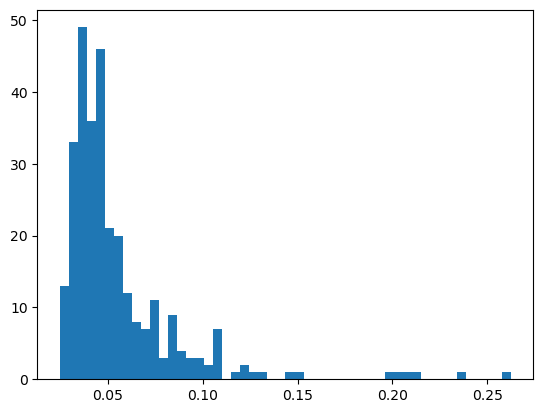

In [185]:
plt.hist(coef_var, bins=50)
plt.show()

(array([2., 3., 0., 1., 0., 1., 2., 4., 0., 1., 0., 0., 0., 0., 2., 2., 0.,
        1., 0., 1.]),
 array([0.04130872, 0.05236231, 0.06341591, 0.07446951, 0.08552311,
        0.0965767 , 0.1076303 , 0.1186839 , 0.1297375 , 0.14079109,
        0.15184469, 0.16289829, 0.17395189, 0.18500548, 0.19605908,
        0.20711268, 0.21816628, 0.22921987, 0.24027347, 0.25132707,
        0.26238067]),
 <BarContainer object of 20 artists>)

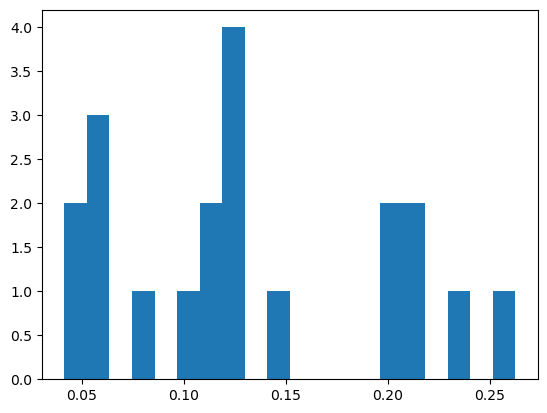

In [198]:
true_coef_var = np.mean(coef_var[true_indices])
true_coef_var
plt.hist(coef_var[true_indices], bins=20)

In [190]:
true_coef_mse = np.mean((coef_avg[true_indices] - coef[true_indices])**2)
true_coef_mse

0.05786680788949945

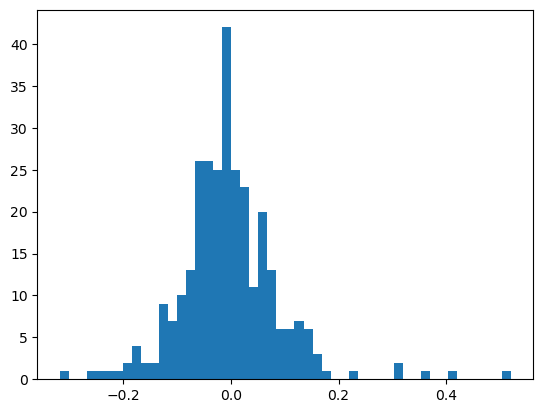

In [191]:
plt.hist(coef_avg - coef, bins = 50)
plt.show()

In [194]:
true_coef_corr = np.corrcoef(coef_mat[true_indices, :], rowvar=False)
true_coef_corr_utri = true_coef_corr[np.triu_indices(true_coef_corr.shape[0], k=1)]
np.mean(true_coef_corr_utri)

0.7690556470919081

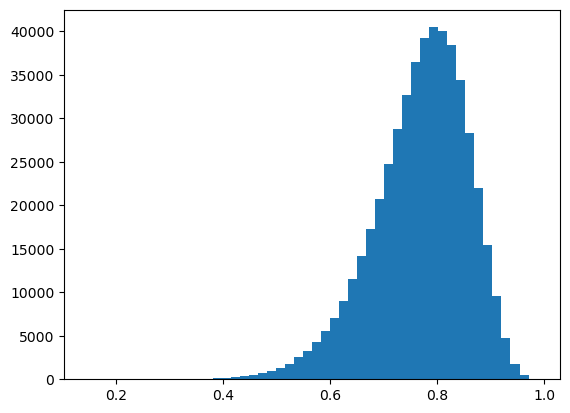

In [197]:
plt.hist(true_coef_corr_utri,  bins=50)
plt.show()

In [195]:
true_coef_mse / true_coef_var

0.438342836166106

In [193]:
coef_mat.shape

(300, 1000)

In [142]:
coef_mat.shape

(300, 500)

In [136]:
coef_corr = np.corrcoef(coef_mat, rowvar=False)
coef_corr_utri = coef_corr[np.triu_indices(coef_corr.shape[0], k=1)]
np.mean(coef_corr_utri)

0.361988966453134

In [143]:
coef_corr.shape

(500, 500)

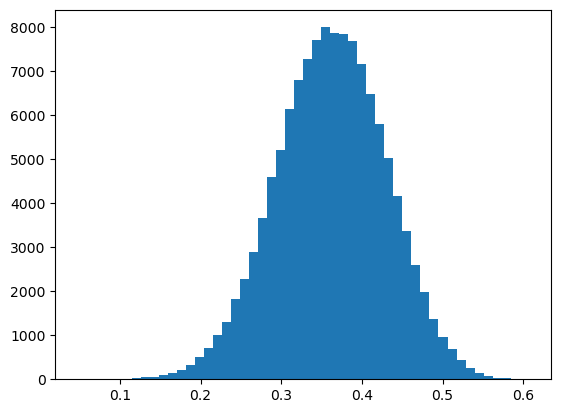

In [140]:
plt.hist(coef_corr_utri, bins = 50)
plt.show()

In [163]:
coef_mse / np.mean(coef_var)

0.15718096309857135